In [1]:
# Load imports and set plotting generics
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits as pyfits
from scipy import signal
from scipy.signal import find_peaks

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 4)
# print(plt.rcParams.keys())
plt.rcParams['image.origin'] = 'lower'

In [2]:
# Load user defined functions
def continuum(wav, counts, deg=11, std=1.6, steps=5, pos=False, plot=False):
    if plot: plt.plot(wav, counts, ".", markersize=0.8)
    
    nw = wav.copy()
    nc = counts.copy()
    
    for i in range(steps):
#         warnings.simplefilter('ignore', np.RankWarning)
        p = np.polynomial.chebyshev.chebfit(nw, nc, deg=deg)
        ch = np.polynomial.chebyshev.chebval(nw, p)
        diff = nc - ch
        sigma = np.std(diff)
        
        ok = np.where(np.abs(diff) > std*sigma) if pos else np.where(diff > -1*std*sigma)
        
        nw = nw[ok]
        nc = nc[ok]
        
        if plot: plt.plot(wav, np.polynomial.chebyshev.chebval(wav, p), label=str(i))
            
    if plot:
        plt.legend()
        plt.show()

        plt.plot(wav, counts/np.polynomial.chebyshev.chebval(wav, p))
        plt.show()
        
    return np.polynomial.chebyshev.chebval(wav, p) # p

def filtered_continuum(spec, bpm, cutoff: float = 0.005, std: float = 1.6, steps: int = 5, plot: bool = False):
    data = np.ma.masked_where((spec == 0) | (bpm.astype(bool)), spec, copy=True)
    
    if plot:
        fig, axs = plt.subplots(2, 1, sharex=True, figsize=[20, 8])
        axs[0].plot(data, label="data")

    for i in range(steps):
        b, a = signal.butter(1, cutoff, "lowpass")
        filt_cont = signal.filtfilt(b, a, data, method="gust")
        
        diff = data - filt_cont
        data = np.ma.masked_where(np.abs(diff) > std * data.std(), data)
        
        if plot:
            axs[0].plot(filt_cont, label=f"cont. {i}")
            axs[0].plot(data - i, label=f"masked data {i}")
        
    if plot:
        axs[1].plot(spec / filt_cont, label="normalised data")
        for ax in axs: ax.legend()
    
    return filt_cont

def grow(maskedarray, growth: int = 1):
    mArr = maskedarray.copy()
    for i, val in enumerate(maskedarray.mask):
        if not val: continue

        mArr.mask[max(0, i - growth): i] = True
        mArr.mask[i: min(i + growth + 1, len(mArr.mask))] = True
            
    return mArr

# function to convert night sky linelist into spectral template
def model_sky(wav, *params):
    wavshift, scale, fwhm, conta, contb = params
    
    # start with the continuum
    model = np.polyval([conta, contb], wav)
    
    # add in each line
    sigma = fwhm / 2.355
    minwav = np.min(wav) - 3 * fwhm
    maxwav = np.max(wav) + 3 * fwhm
    w = ((SKYLINES['wav'] + wavshift) >= minwav) & ((SKYLINES['wav'] + wavshift) <= maxwav)
    for line in skylines[w]:
        # assume lines are Gaussian
        model += scale * line['flux'] * np.exp( -(wav - line['wav'] - wavshift) ** 2 / 2 / sigma ** 2)
        
    return model

def col_to_wav(coeff, cols):
    return np.polyval(coeff, cols)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def Gauss(x, a, x0, sigma, offset):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + offset

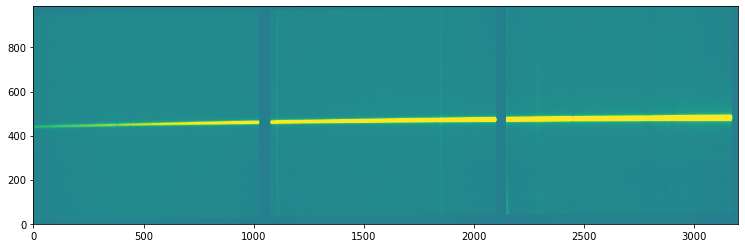

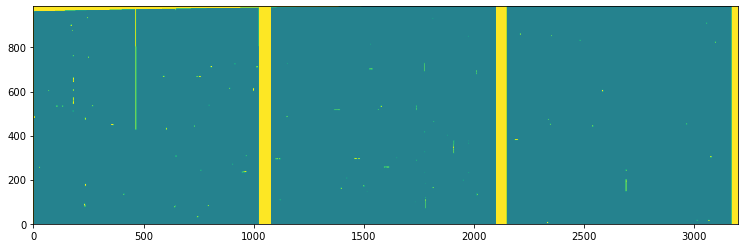

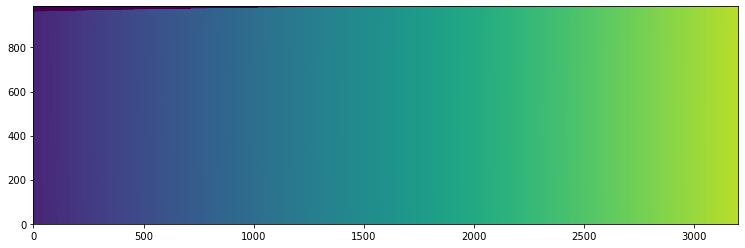

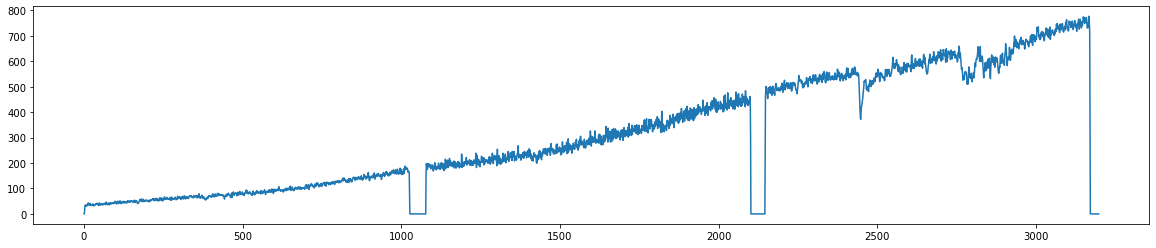

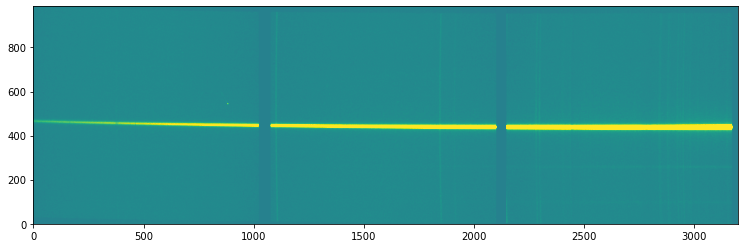

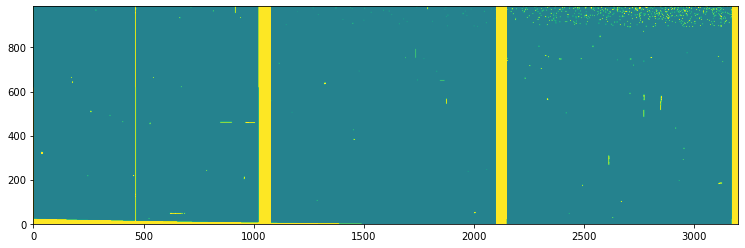

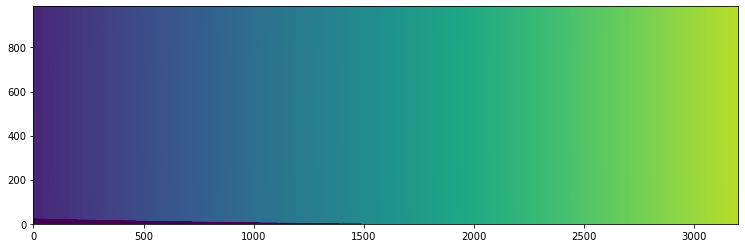

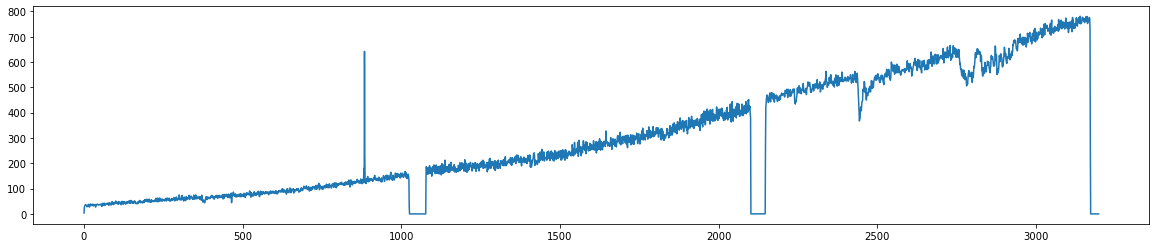

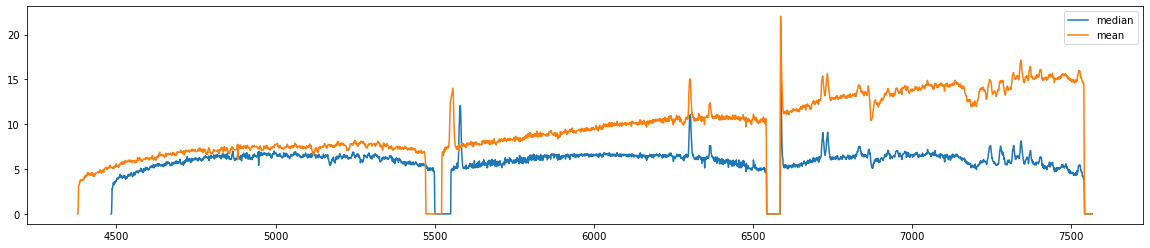

In [3]:
# Load data (and optionally display)
with pyfits.open("NGC_20241/sci/wmxgbpP201701130035.fits") as hdul:
    frameOE = hdul["SCI"].data
    bpmOE   = hdul["BPM"].data
    waveOE  = hdul["WAV"].data

for j in [0, 1]:
    for i in [frameOE, bpmOE, waveOE]:
        plt.imshow(i[j],vmax=i[j].mean() + 2*np.std(i[j]), vmin=i[j].mean() - 2*np.std(i[j]))
        plt.show()

    plt.plot(np.max(frameOE[j], axis=0))
    plt.show()

plt.plot(np.median(waveOE[0], axis=0), np.median(frameOE[0], axis=0), label="median")
plt.plot(np.mean(waveOE[0], axis=0), np.mean(frameOE[0], axis=0), label="mean")
plt.legend()

Average continuum of O at 6.137


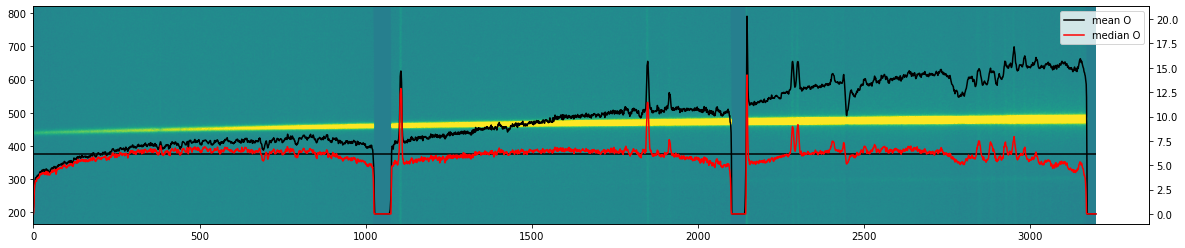

Average continuum of E at 4.522


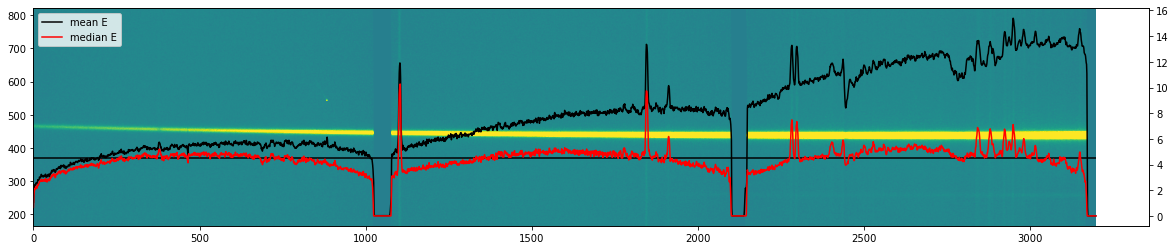

In [7]:
# Loaded data has non-uniform wavelength solution
# Work out corrected data
cfOE = np.zeros_like(frameOE)
cwOE = np.zeros_like(waveOE)

for ext in range(frameOE.shape[0]):
    
    # Get middle row (to interpolate the rest of the rows to)
    avg_max = [np.where(frameOE[ext][:, col] == frameOE[ext][:, col].max())[0][0] for col in range(frameOE[ext].shape[1])]
    avg_max = np.sum(avg_max) // frameOE[ext].shape[1]
    
    # Get wavelength values at above row
    wav = waveOE[ext][avg_max, :]
    
    # Correct extensions based on wavelength
    cwOE[ext][:, :] = wav
    for row in range(frameOE[ext].shape[0]):
        cfOE[ext][row, :] = np.interp(wav, waveOE[ext][row, :], frameOE[ext][row, :])
    
    # Plot results
    fig, ax1 = plt.subplots(figsize=[20, 4])
    ax1.imshow(cfOE[ext],
               vmax=cfOE[0].mean() + 2*cfOE[0].std(),
               vmin=cfOE[0].mean() - 2*cfOE[0].std(),
               origin='lower')
    print(f"Average continuum of {'E' if ext else 'O'} at {np.median(np.median(cfOE[ext], axis=0)):4.3f}")
    ax2 = ax1.twinx()
    ax2.hlines(np.median(np.median(cfOE[ext], axis=0)), 0, cfOE[ext].shape[-1], colors='black')
    ax2.plot(cfOE[ext].mean(axis=0), "k", label=f"mean {'E' if ext else 'O'}")
    ax2.plot(np.median(cfOE[ext], axis=0), "r", label=f"median {'E' if ext else 'O'}")
    ax2.legend()
    plt.show()
    
    # plt.plot(cfOE[ext].mean(axis=0) - np.median(cfOE[ext], axis=0)) # Difference between mean and median
    # plt.show()
        
        
################################
# for ext in [0, 1]:
    
#     # Find rows with little trace
#     ok_wav  = frameOE[ext].mean(axis=1) <= frameOE[ext].mean() - 0.078 * frameOE[ext].std()
#     no_trace = np.arange(0, len(frameOE[ext].mean(axis=1)))[ok_wav]
#     plt.plot(no_trace, np.median(frameOE[ext], axis=1)[ok_wav], ".", label=f"avg{'E' if ext else 'O'}")
#     plt.hlines([frameOE[ext].mean(), frameOE[ext][ok_wav].mean()], 0, 1000)
#     plt.legend()
#     print(frameOE[ext].mean(), frameOE[ext][ok_wav].mean())
    
#     for row in no_trace:#range(frameOE[ext].shape[0]): # TODO: Skip rows if contains a trace
#         cfOE[ext][row, :] = np.interp(wav, waveOE[ext][row, :], frameOE[ext][row, :])

In [8]:
# Tried to optimize Gaussian curves to fit continuum since func continuum failed
# %%time
# from scipy.optimize import curve_fit

# gauss_fits = np.zeros([cfOE.shape[0], cfOE.shape[-1], 4])
# #print("\ta\tx0\t\tsigma\t\toffset")
# for ext in range(cfOE.shape[0]):
#     for col in range(cfOE[ext].shape[-1]):
#         try:
#             if np.median(cfOE[ext, :, col]) == 0: gauss_fits[ext, col] = [0, 0, 0, 0]
#             popt, pcov = curve_fit(Gauss,
#                                    np.arange(0, len(cfOE[ext, :, col])),
#                                    cfOE[ext, :, col],
#                                    p0=[cfOE[ext, :, col].max(),
#                                        cfOE[ext, :, col].argmax(),
#                                        10,
#                                        cfOE[ext, :, col].mean()])
#             gauss_fits[ext, col] = popt
#         except RuntimeError:
#             print(f"No optimal gauss parameters at {ext, col}")
#             gauss_fits[ext, col] = [0, 0, 0, 0]

In [16]:
# Load skylines
loadFrom = "Growth"

if loadFrom.lower() == "growth":
    # load skylines (from GROWTH)
    data_dir = os.path.join('/media/justin/Transcend/Growth_school_2020', 'spectroscopy', 'data')
    wildcard = os.path.join(data_dir, 'UVES', '*dat')

    dtype = []
    dtype.append( ('seq', int) )
    dtype.append( ('wav', float) )
    dtype.append( ('intensity', float) )
    dtype.append( ('fwhm', float) )
    dtype.append( ('flux', float) )

else:
    # Load skylines (from IRAF/SALT)
    data_dir = os.path.join("/home/justin/iraf/pysalt/data/linelists")
    wildcard = os.path.join(data_dir, "sky.salt") # No wildcard for IRAF/SALT, defined for flow

    dtype = []
    dtype.append( ('wav', float) )
    dtype.append( ('flux', float)) # Assumed flux, no column label/units in file


skylines = np.array([], dtype=dtype)
fnames = glob(wildcard)
for fname in fnames:
    lines = np.genfromtxt(fname, dtype=dtype, skip_header=3, skip_footer=1)
    skylines = np.hstack([skylines, lines])
    
SKYLINES = skylines

In [34]:
SKYLINES[0].dtype.names

('seq', 'wav', 'intensity', 'fwhm', 'flux')

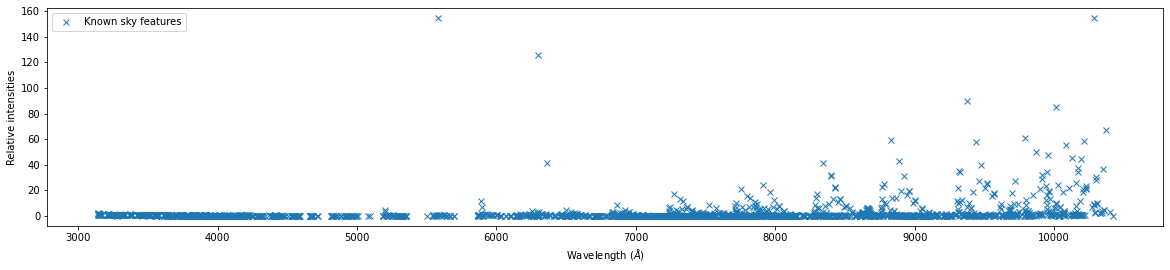

In [29]:
# Show loaded skylines and data range skyline model
plt.plot(SKYLINES['wav'], SKYLINES['flux'], "x", label="Model peaks")

skymodel = model_sky()

# for ext in range(cfOE.shape[0]):
#     x = cwOE[ext, 400, :]
#     y = np.median(cfOE[ext], axis=0)
#     fun = np.zeros([cfOE[ext, 400, :].shape[0]])
    
#     for w, f in zip(wsky, fsky): fun += Gauss(x, f, w, 1, 0)
# #     plt.plot(x, y, label=f"median {'E' if ext else 'O'}")
# #     plt.plot(x, Gauss(x, 2, 5000, 300, 3) + Gauss(x, 2, 6050, 300, 0) + Gauss(x, 2, 7050, 300, 0))

# plt.plot(x, fun, label="Sky Model in data range")

plt.legend()
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Relative intensities')
plt.show()

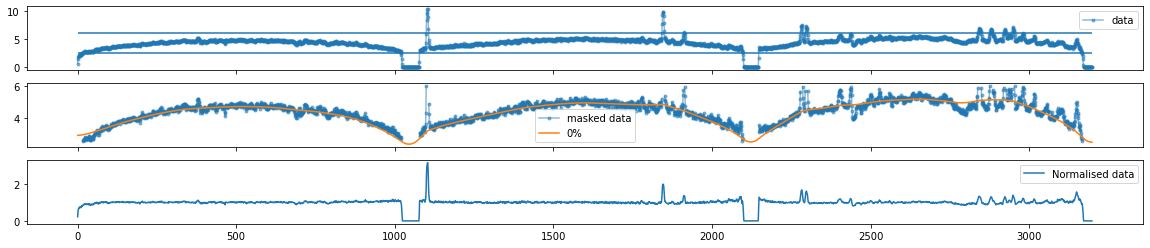

In [9]:
# Load data
data = np.median(cfOE[ext], axis=0)[:]
ll, ul = data.mean() - 1.5 * data.std(), data.mean() + 1.5 * data.std()
mdat = np.ma.masked_where((data < ll) | (data > ul), data)

# Setup plot
fig, axs = plt.subplots(3, 1, sharex=True)

# Plot data and lower/upper limits
axs[0].plot(data, '.-', alpha=.5, label="data")
axs[0].hlines([ll, ul], 0, len(data))

# Fit signal filter to masked data
cutoff  = 0.005 # %
b, a = signal.butter(1, cutoff, "lowpass")
# b, a = signal.butter(1, [0.01, 0.2], "band")
# filtered = signal.filtfilt(b, a, mdat)
filtered = signal.filtfilt(b, a, mdat, method="gust")


# Plot masked data and filter (or continuum)
axs[1].plot(mdat, '.-', alpha=.5, label="masked data")
axs[1].plot(filtered, label=f"{int(cutoff*100):d}%")

axs[2].plot(data / filtered, label="Normalised data")


for ax in axs: ax.legend()
plt.show()

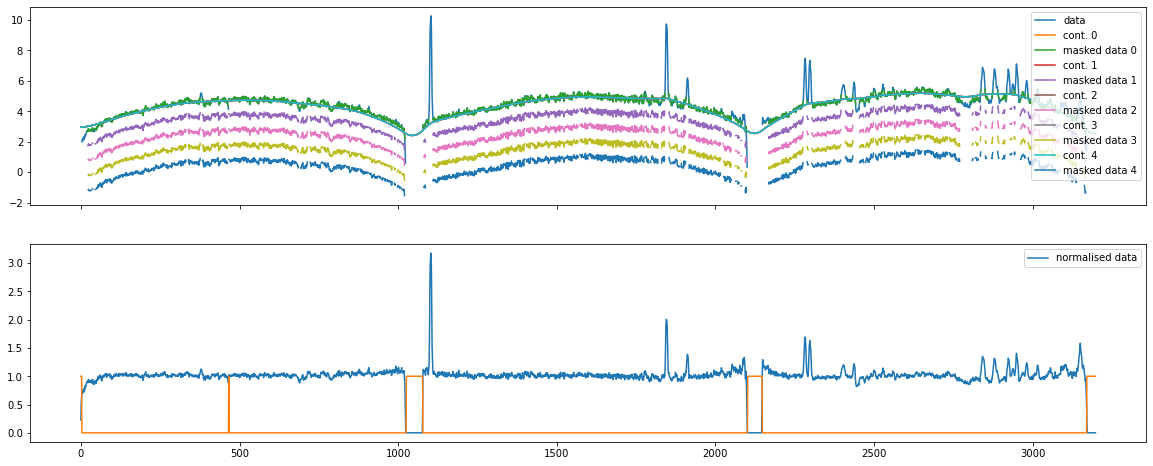

In [7]:
# plt.plot(data)
f_cont = filtered_continuum(np.median(cfOE[ext], axis=0), np.median(bpmOE[0], axis=0), std=0.5, plot=True)

plt.plot(np.median(bpmOE[0], axis=0))

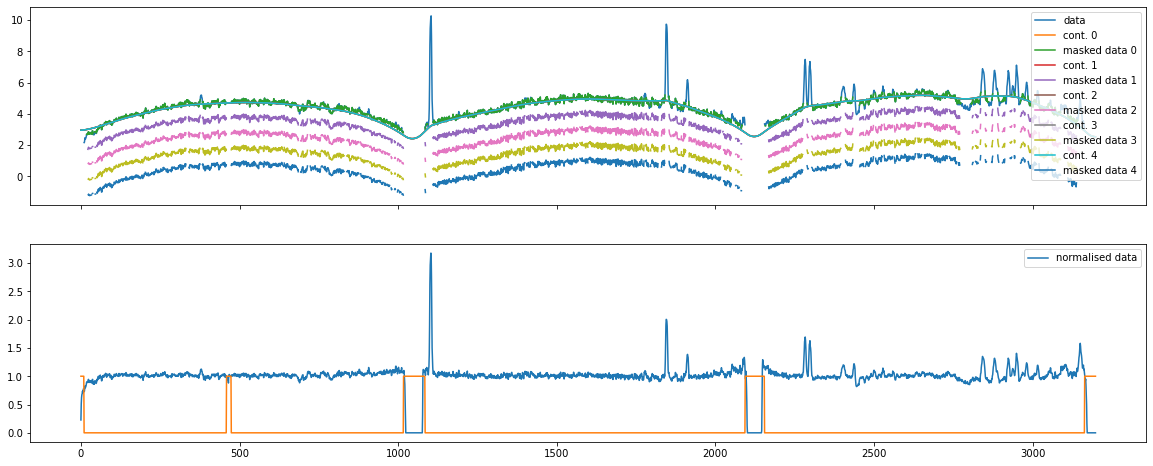

In [13]:
data = np.ma.masked_where((np.median(cfOE[ext], axis=0) == 0) | (np.median(bpmOE[0], axis=0).astype(bool)),
                          np.median(cfOE[ext], axis=0), copy=True)

data = grow(data, 7)
f_cont = filtered_continuum(data.data, data.mask, std=0.5, plot=True)
plt.plot(data.mask)

Text(0, 0.5, 'Counts')

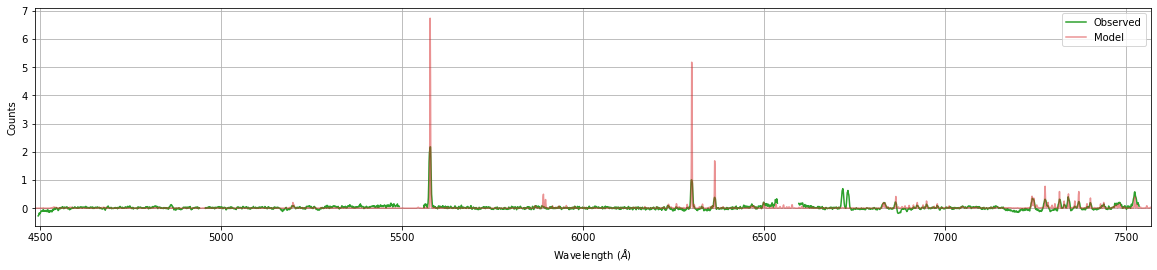

In [16]:
# get starting guess for the fwhm and flux scaling
sky_norm = data / f_cont - 1
# wavs = col_to_wav(coeff2, np.arange(sky_norm.size))
wavs = cwOE[0][0, :]
params = (0, 1, 2, 0, 0)
plt.plot(model_sky(wavs[0], *params))
plt.plot(model_sky(wavs[-1], *params))
skymodel = model_sky(wavs, *params)
w = skymodel > 1
scale = np.mean(sky_norm[w] / skymodel[w])

plt.plot(wavs, sky_norm, label='Observed')
plt.plot(wavs, scale * skymodel, label='Model', alpha=0.5)
plt.legend()
plt.grid()
plt.xlim([wavs[0], wavs[-1]])
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Counts')

1024	 379 - 4861.4 - 4.53
1025	1104 - 5578.1 - 10.27
 977	1845 - 6299.0 - 6.43
 203	1912 - 6363.4 - 2.04
1027	2283 - 6717.5 - 7.48
 881	2298 - 6731.7 - 2.88
 117	2403 - 6831.0 - 1.09
 137	2437 - 6863.1 - 1.69
 356	2528 - 6948.7 - 1.55
 418	2842 - 7241.4 - 2.38
  33	2880 - 7276.6 - 2.25
  36	2923 - 7316.3 - 1.63
 727	2949 - 7340.2 - 3.16
 215	2981 - 7369.7 - 1.44
 171	3016 - 7401.8 - 1.04
  35	3150 - 7524.3 - 1.66


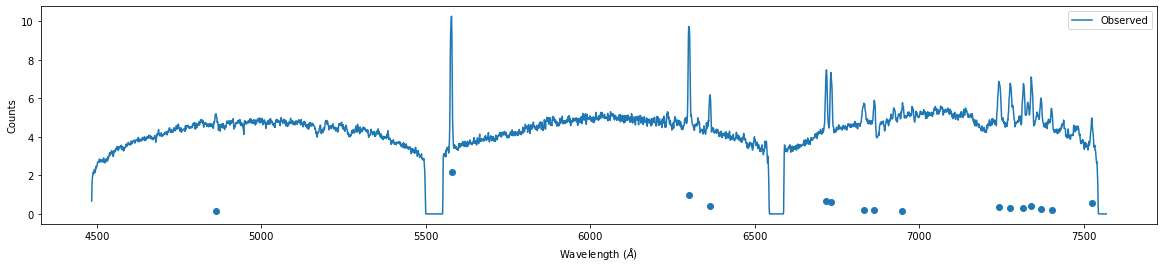

In [17]:
# locate observed sky line peaks (roughly)
# skyline_cols, properties = find_peaks(sky_norm, prominence=0.2) # 1000 # prominence is basically the ylimit above which peaks should be found
skyline_cols, properties = find_peaks(data, prominence=1)
skyline_wavs = wavs[skyline_cols] # col_to_wav(coeff2, skyline_cols)

# plt.plot(wavs, sky_norm, label='Observed')
plt.plot(wavs, data.data, label='Observed')
plt.scatter(skyline_wavs, sky_norm[skyline_cols]);

plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Counts')
plt.legend()

for i in range(len(skyline_cols)):
    print(f"{properties['right_bases'][i] - properties['left_bases'][i]:4d}\t{skyline_cols[i]:4d} - {wavs[skyline_cols][i]:.1f} - {properties['prominences'][i]:.2f}")

No handles with labels found to put in legend.


Text(0, 0.5, 'Closest Difference')

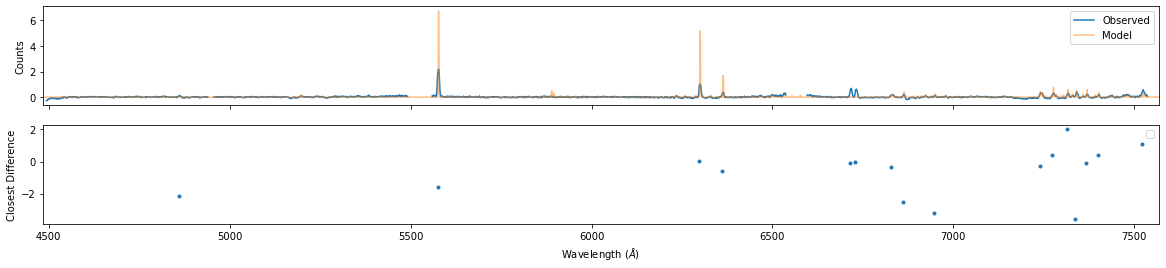

In [37]:
closest_point = []
for point in wav[skyline_cols]:
    closest_point.append(point - find_nearest(SKYLINES['wav'], point))

#Skip over points that are further than a certain distance
close_w = np.abs(closest_point) < 20
# plt.plot(model_sky(wavs[0], *params))
# plt.plot(model_sky(wavs[-1], *params))

fig, axs = plt.subplots(3, sharex=True)

axs[0:2].plot(wavs, sky_norm, label='Observed')
axs[0:2].plot(wavs, scale * skymodel, label='Model', alpha=0.5)

axs[2].plot(wav[skyline_cols][close_w], np.array(closest_point)[close_w], ".")
axs[2].grid()
for ax in axs: ax.legend()
for ax in axs: ax.set_xlim([wavs[0], wavs[-1]])

axs[2].set_xlabel('Wavelength ($\AA$)')

axs[0:2].set_ylabel('Counts')
axs[2].set_ylabel('Closest Difference')

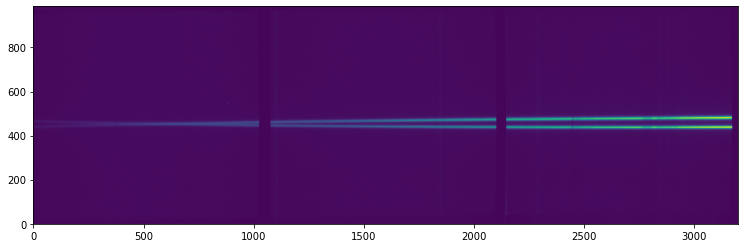

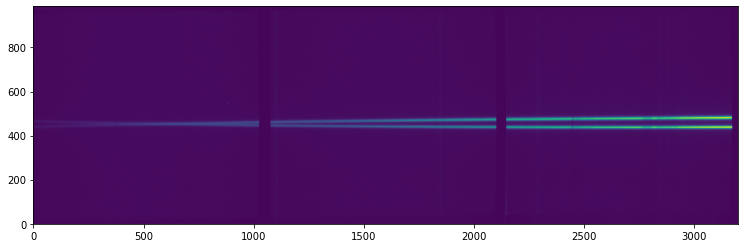

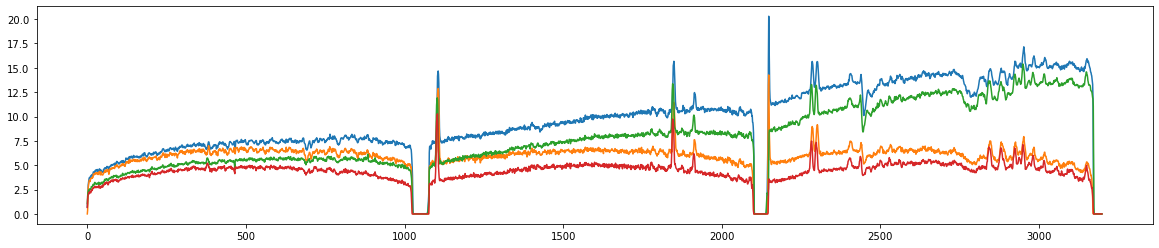

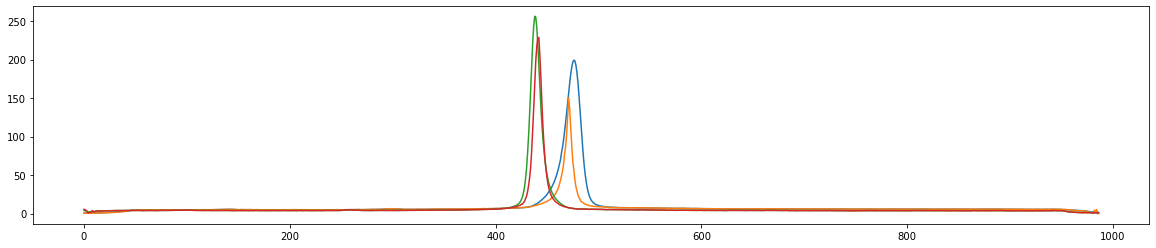

In [18]:
plt.imshow(np.median(cfOE, axis=0))
plt.show()
plt.imshow(np.mean(cfOE, axis=0))
plt.show()

for i in [1, 2]:
    for ext in [0, 1]:
        plt.plot(np.mean(cfOE, axis=i)[ext])
        plt.plot(np.median(cfOE, axis=i)[ext])
    plt.show()